# Fidelity-Interpretability analysison the animals dataset

The animals dataset is a subset of the [ILSVRC 2012](http://image-net.org/challenges/LSVRC/2012/), that contains only the classes regarding animals. We prefer this over the complete ImageNet datasetfor a few reasons:

- It is a bit smaller (roughly $40\%$ the size of ImageNet) which allows for more experiments.
- It is more difficult to distinguish between the classes, causing the overall task to be harder. This is because we threw out a large portion of the easily-classifiable classes (e.g. street signs), while keeping the hader ones (e.g. tabby cat, tiger cat, Persian cat, Siamese cat, Egyptian cat).

Since it's the hardest of all the datasets, the baseline and classification performance is expected to be quite low.

In [1]:
import sys
sys.path.append('..')

from utils.plotting import *

%matplotlib inline

/home/thanos/.envs/dl/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/thanos/.envs/dl/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/thanos/.envs/dl/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/thanos/.envs/dl/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.

Load the baseline.

In [2]:
baseline_loc = '../results/animals/seeker/default/baseline.txt'
with open(baseline_loc) as f:
    baseline = float(f.read())
print('Baseline accuracy: {:.2f}%'.format(baseline * 100))

Baseline accuracy: 0.26%


Load the logs.

In [3]:
def read_hns_epoch_logs(path_to_events_file):
    logs = {'Average loss per epoch': [],
            'Validation accuracy': []}

    for e in tf.compat.v1.train.summary_iterator(path_to_events_file):
        for v in e.summary.value:
            logs[v.tag].append(struct.unpack('f', v.tensor.tensor_content)[0])

    if len(logs['Validation accuracy']) < len(logs['Average loss per epoch']):
        logs['Validation accuracy'].append(logs['Validation accuracy'][-1])

    return pd.DataFrame(logs)

def read_hns_batch_logs(path_to_events_file):
    logs = {'classification loss': [],
            'gradients': [],
            'loss monitor': [],
            'loss regulator': [],
            'mask loss': [],
            'percentage hidden': [],
            'pixels hidden': [],
            'pixels kept': [],
            'total loss': []}

    for e in tf.compat.v1.train.summary_iterator(path_to_events_file):
        for v in e.summary.value:
            logs[v.tag].append(struct.unpack('f', v.tensor.tensor_content)[0])
            
    min_length = min([len(logs[k]) for k in logs])
    
    for k, v in logs.items():
        if len(v) > min_length:
            v.pop()
            
    return pd.DataFrame(logs)

In [4]:
location = '../logs/animals/hns/stochastic/st1/pretrained_seeker_const_a_0.98'
epoch_logs = read_hns_epoch_logs(str(next((Path(location) / 'epoch').glob('*'))))
batch_logs = read_hns_batch_logs(str(next((Path(location) / 'batch').glob('*'))))

W0916 12:20:22.355972 139662572812032 deprecation.py:323] From /home/thanos/.envs/dl/lib/python3.5/site-packages/tensorflow/python/summary/summary_iterator.py:68: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Plot fidelity and interpretability curves on the same figure. Identify the max fidelity and see the corresponding interpretability.

/home/thanos/.envs/dl/lib/python3.5/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return bound(*args, **kwds)


Text(0.5, 1.0, 'Fidelity and Interpretability')

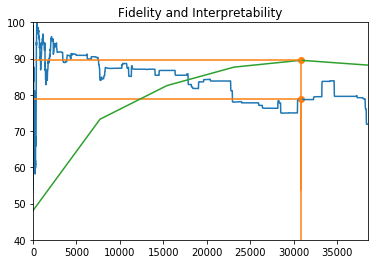

In [5]:
x = np.linspace(0, len(batch_logs), len(epoch_logs))

max_fidelity_loc = np.argmax(epoch_logs['Validation accuracy'])
max_fidelity = epoch_logs['Validation accuracy'].iloc[max_fidelity_loc] / baseline
interpretability_resampled_loc = int(x[max_fidelity_loc])
interpretability = batch_logs['percentage hidden'].iloc[interpretability_resampled_loc]

plt.plot(batch_logs['percentage hidden'])
plt.plot([interpretability_resampled_loc, interpretability_resampled_loc], [min(batch_logs['percentage hidden']), interpretability])
plt.plot([0, interpretability_resampled_loc], [interpretability, interpretability], color='C1')
plt.scatter([interpretability_resampled_loc], [interpretability], color='C1', zorder=0)

plt.plot(x, epoch_logs['Validation accuracy'] / baseline)
plt.plot([interpretability_resampled_loc, interpretability_resampled_loc], [min(epoch_logs['Validation accuracy']), max_fidelity], c='C1')
plt.plot([0, interpretability_resampled_loc], [max_fidelity, max_fidelity], color='C1')
plt.scatter([interpretability_resampled_loc], [max_fidelity], color='C1', zorder=0)

plt.xlim(0, x[-1])
plt.ylim(40, 100)

plt.title('Fidelity and Interpretability')

Plot the Fidelity-to-Interpretability Ration (FIR).

/home/thanos/.envs/dl/lib/python3.5/site-packages/pandas/core/series.py:942: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


Text(0.5, 1.0, 'FIR')

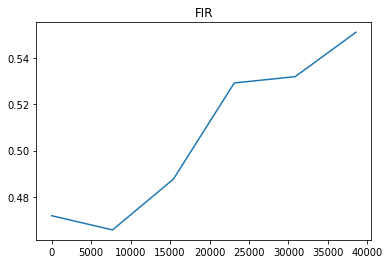

In [6]:
fidelity = epoch_logs['Validation accuracy'] / baseline
interpret = batch_logs['percentage hidden'][x.astype(int)].fillna(batch_logs['percentage hidden'].iloc[-1]).values
fir = fidelity / (interpret + fidelity)
plt.plot(x, fir)

plt.title('FIR')

Numeric info.

In [7]:
print('Peak Fidelity:                  ', fidelity[max_fidelity_loc])
print('Interpretability at that point: ', interpret[max_fidelity_loc])
print('FIR at that point:              ', fir[max_fidelity_loc])

Peak Fidelity:                   89.53488644968478
Interpretability at that point:  78.81639099121094
FIR at that point:               0.5318337217911424
